# DSCI100 Final Project Report 

###  By Pouya Khoshnavazi, Tom Shi, Ege Taslicay, Rudra Patel

## Section 1 - Introduction

We will begin by loading in the libraries we need for our wrangling and predictions.

In [2]:
library(tidyverse) 
library(repr)
library(lubridate)
options(repr.matrix.max.rows = 6)
library(hms)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘hms’


The following object is masked from ‘package:lubridate’:

    hms




**Background Information:**

This project report uses 2 datasets extracted from the Plaicraft project at UBC. We have one data set with information about players which are observations and another with information about play sessions. 

PlaiCraft is a minecraft server setup by UBC to gather data on human play sessions. 

We will use these 2 datasets to make a prediction that will help us answer our predictive question.


**Question:**

Our specific question would be whether a player's age and experience level can accurately predict a player's total played hours using knn-regression to obtain players that contribute the largest amount of data.

**Data Description**

The data for this project consists of two files: one for player data and one for session data.

**Players File (players.csv):**
- **Number of observations / Rows**: 196
- **Number of variables / Columns**: 9
- **Variables**:
  - **experience**: Categorical, indicating player’s experience level (e.g., Beginner, Pro).
  - **subscribe**: Categorical, indicating email subscription status.
  - **hashedEmail**: Unique hashed identifier for each players email.
  - **played_hours**: Numerical, total hours played.
  - **name**: Player’s name.
  - **gender**: Categorical (e.g., Male, Female) players gender.
  - **age**: Numeric, player’s age.
  - **individualId**: Empty column.
  - **organizationName**: Empty column.

**Sessions File (sessions.csv):**
- **Number of observations / Rows**: 1,535
- **Number of variables / Columns**: 5
- **Variables**:
  - **hashedEmail**: Hashed identifier linking to players.
  - **start_time**: Date, session start time.
  - **end_time**: Date, session end time.
  - **original_start_time**: Unix timestamp for session start.
  - **original_end_time**: Unix timestamp for session end.

**Potential Issues**:
- **Missing data**: Some cells may be empty; `individualId` and `organizationName` are empty.
- **Unix Time**: May need conversion for better usability or removal since redundant.


## Section 2 - Methods and results

Rows: 196 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, age
lgl (3): subscribe, individualId, organizationName

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Warning message:
“Expected 2 pieces. Missing pieces filled with `NA` in 3 rows [106, 1221, 1222].”
Warning message:
“Expected 2 pieces. Missing pieces filled with `NA` in 4 rows [52, 1063, 1066,
1238].”


hashedEmail,start_date,start_time_only,end_date,end_time_only
<chr>,<chr>,<chr>,<chr>,<chr>
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,2024-06-30,18:12:00,2024-06-30,18:24:00
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,2024-06-17,23:33:00,2024-06-17,23:46:00
f8f5477f5a2e53616ae37421b1c660b971192bd8ff77e3398304c7ae42581fdc,2024-07-25,17:34:00,2024-07-25,17:57:00
⋮,⋮,⋮,⋮,⋮
fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d,2024-07-28,15:36:00,2024-07-28,15:57:00
fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d,2024-07-25,06:15:00,2024-07-25,06:22:00
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,2024-05-20,02:26:00,2024-05-20,02:45:00


experience,hashedEmail,played_hours,name,gender,age
<chr>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
⋮,⋮,⋮,⋮,⋮,⋮
Amateur,d572f391d452b76ea2d7e5e53a3d38bfd7499c7399db299bd4fedb06a46ad5bb,0.0,Dylan,Prefer not to say,17
Amateur,f19e136ddde68f365afc860c725ccff54307dedd13968e896a9f890c40aea436,2.3,Harlow,Male,17
Pro,d9473710057f7d42f36570f0be83817a4eea614029ff90cf50d8889cdd729d11,0.2,Ahmed,Other,91


Warning message in scale_y_log10():
“log-10 transformation introduced infinite values.”


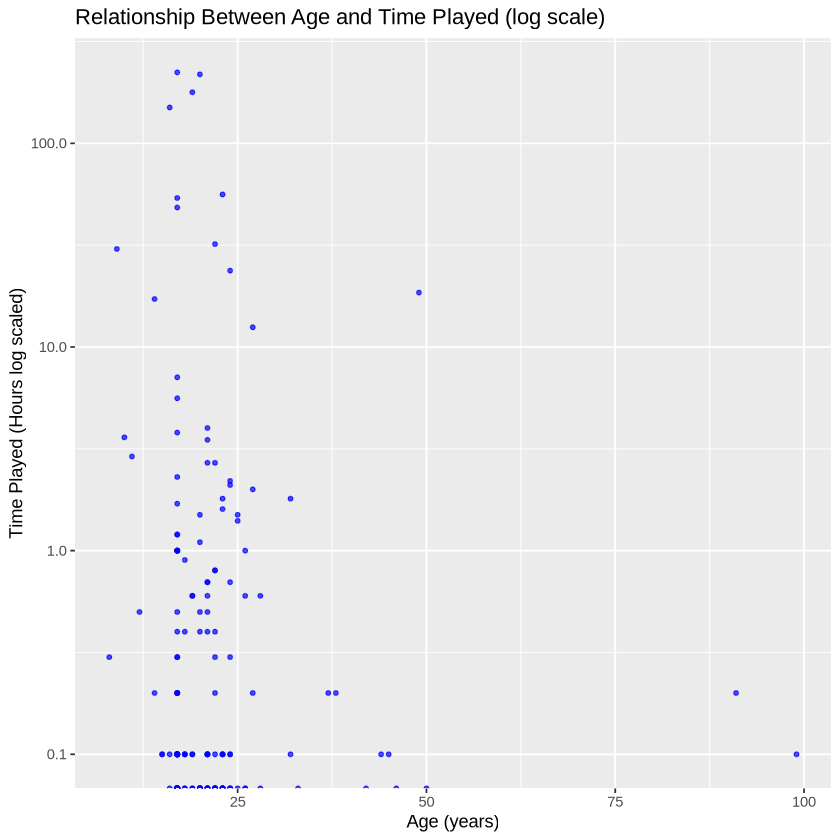

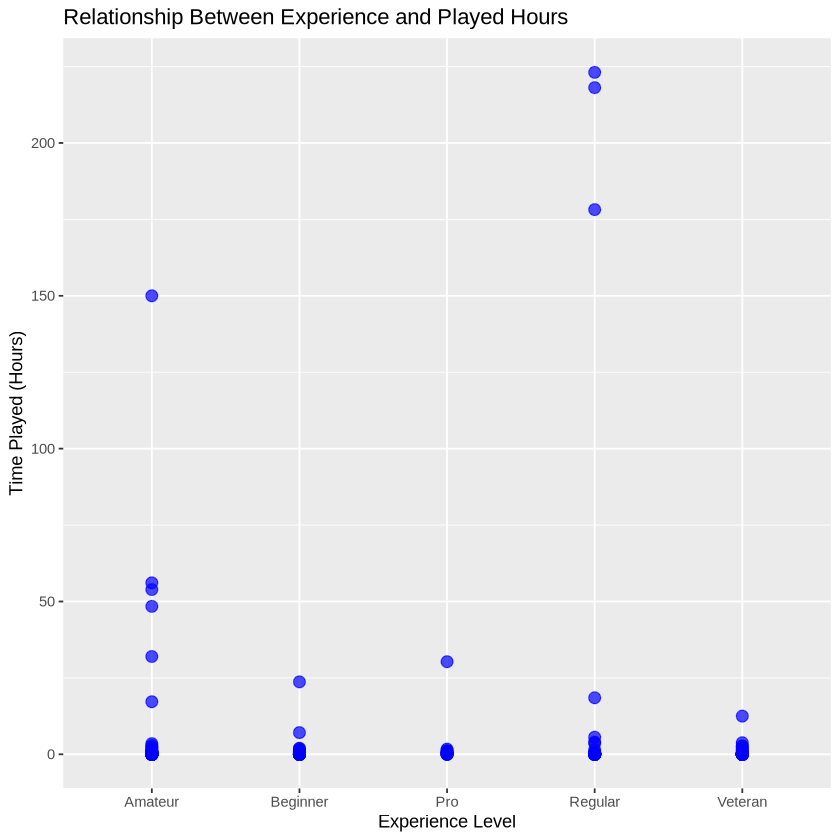

In [4]:
# Reading data into R from given link.

player_data <- read_csv("https://drive.google.com/uc?export=download&id=1Mw9vW0hjTJwRWx0bDXiSpYsO3gKogaPz")

session_data <- read_csv("https://drive.google.com/uc?export=download&id=14O91N5OlVkvdGxXNJUj5jIsV5RexhzbB")


# cleaned data by only including non empty columns 

player_data <- player_data |>
          select(experience, hashedEmail, played_hours,	name, gender, age) 


# seperated date and time into two seperate columns since you can only have one value in a single cell
# removed original_start_time and original_end_time since they are in unix time arent very useful as we already have start_time and end_time and 
# do not provide valuable session length data since subtracting them gives 0 in most cases 

session_data <- session_data |>
  mutate(start_time = dmy_hm(start_time), end_time = dmy_hm(end_time)) |>
  separate(start_time, into = c("start_date", "start_time_only"), sep = " ", convert = TRUE) |>
  separate(end_time, into = c("end_date", "end_time_only"), sep = " ", convert = TRUE) |>
  select(hashedEmail, start_date, start_time_only, end_date, end_time_only)

session_data

player_data


# mutate(experience_num = case_when(experience == "Amateur" ~ 1,
#                                   experience == "Pro" ~ 5,
#                                   ...)
#        # start with 0 or 1, whatever you want. also check me on amateur being the bottom lol



# scatter plot with age on x axis and played_hours on y axis 
# age_and_time_plot <- player_data |>
#   ggplot(aes(x = age, y = played_hours)) +
#   geom_point(color = "blue", size = 1, alpha = 0.7) +
#   labs(title = "Relationship Between Age and Time Played (log scale)", x = "Age (years)", y = "Time Played (Hours log scaled)") +
#   scale_y_log10()

# age_and_time_plot


# # scatter plot with experience on x axis and played_hours on y axis 
# experience_and_time_plot <- player_data |>
#   ggplot(aes(x = experience, y = played_hours)) +
#   geom_point(color = "blue", size = 3, alpha = 0.7) +  
#   labs(title = "Relationship Between Experience and Played Hours", x = "Experience Level", y = "Time Played (Hours)") 

# experience_and_time_plot
